<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/05wk-2
    .ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [2]:
# {{<video https://youtu.be/playlist?list=PLQqh36zP38-yx6DQsLACqw8pWm0udv8Jm&si=in1eMD0-wU49y7mS >}}

# 2. Imports

In [3]:
import torch
import matplotlib.pyplot as plt

In [4]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

# 3. CPU vs GPU 

`-` 파이토치에서 GPU를 쓰는 방법을 알아보자. (사실 지금까지 우리는 CPU만 쓰고 있었음) 

`-` 코랩에서 GPU설정하는 방법: (아래영상참고)

{{<video https://youtu.be/GyBL2YBCzoc >}}

## A. GPU 사용방법 

`-` cpu 연산이 가능한 메모리에 데이터 저장

In [5]:
torch.manual_seed(43052)
x_cpu = torch.tensor([0.0,0.1,0.2]).reshape(-1,1) 
y_cpu = torch.tensor([0.0,0.2,0.4]).reshape(-1,1) 
net_cpu = torch.nn.Linear(1,1) 

`-` gpu 연산이 가능한 메모리에 데이터 저장 

In [6]:
!nvidia-smi # before

Thu Apr  3 17:51:16 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:09:00.0 Off |                  N/A |
|  0%   32C    P8              27W / 420W |    661MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
torch.manual_seed(43052)
x_gpu = x_cpu.to("cuda:0")
y_gpu = y_cpu.to("cuda:0")
net_gpu = torch.nn.Linear(1,1).to("cuda:0") 

In [8]:
!nvidia-smi

Thu Apr  3 17:51:17 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.230.02             Driver Version: 535.230.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:09:00.0 Off |                  N/A |
|  0%   36C    P2              57W / 420W |    920MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

> GPU에 메모리를 올리면 GPU메모리가 점유된다! (26MiB -> 287MiB) 

`-` cpu 혹은 gpu 연산이 가능한 메모리에 저장된 값들을 확인 

In [9]:
x_cpu, y_cpu, net_cpu.weight, net_cpu.bias

(tensor([[0.0000],
         [0.1000],
         [0.2000]]),
 tensor([[0.0000],
         [0.2000],
         [0.4000]]),
 Parameter containing:
 tensor([[-0.3467]], requires_grad=True),
 Parameter containing:
 tensor([-0.8470], requires_grad=True))

In [10]:
x_gpu, y_gpu, net_gpu.weight, net_gpu.bias

(tensor([[0.0000],
         [0.1000],
         [0.2000]], device='cuda:0'),
 tensor([[0.0000],
         [0.2000],
         [0.4000]], device='cuda:0'),
 Parameter containing:
 tensor([[-0.3467]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.8470], device='cuda:0', requires_grad=True))

`-` gpu는 gpu끼리 연산가능하고 cpu는 cpu끼리 연산가능함 

(예시1)

In [11]:
net_cpu(x_cpu) 

tensor([[-0.8470],
        [-0.8817],
        [-0.9164]], grad_fn=<AddmmBackward0>)

(예시2)

In [12]:
net_gpu(x_gpu) 

tensor([[-0.8470],
        [-0.8817],
        [-0.9164]], device='cuda:0', grad_fn=<AddmmBackward0>)

(예시3)

In [13]:
net_cpu(x_gpu) 

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

(예시4)

In [14]:
net_gpu(x_cpu)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

(예시5)

In [15]:
torch.mean((y_cpu-net_cpu(x_cpu))**2)

tensor(1.2068, grad_fn=<MeanBackward0>)

(예시6)

In [16]:
torch.mean((y_gpu-net_gpu(x_gpu))**2)

tensor(1.2068, device='cuda:0', grad_fn=<MeanBackward0>)

(예시7)

In [17]:
torch.mean((y_gpu-net_cpu(x_cpu))**2)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

(예시8)

In [18]:
torch.mean((y_cpu-net_gpu(x_gpu))**2)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

## B. 시간측정 (예비학습) 

In [19]:
import time 

In [20]:
t1 = time.time()

In [21]:
t2 = time.time()

In [22]:
t2-t1

0.14690208435058594

## C. CPU vs GPU (500 nodes)

`-` CPU (500 nodes) 

In [23]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1)
y=torch.randn(100).reshape(-1,1)*0.01
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,500),
    torch.nn.ReLU(),
    torch.nn.Linear(500,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
t1 = time.time()
for epoc in range(1000):
    # 1 
    yhat = net(x)
    # 2 
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

0.4291534423828125

`-` GPU (500 nodes) 

In [24]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1).to("cuda:0")
y=(torch.randn(100).reshape(-1,1)*0.01).to("cuda:0")
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,500),
    torch.nn.ReLU(),
    torch.nn.Linear(500,1)
).to("cuda:0")
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
t1 = time.time()
for epoc in range(1000):
    # 1 
    yhat = net(x)
    # 2 
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

0.5187954902648926

- CPU가 더 빠르다??

## D. CPU vs GPU (200,000 nodes)

`-` CPU (200,000)

In [25]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1)
y=torch.randn(100).reshape(-1,1)*0.01
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,200000),
    torch.nn.ReLU(),
    torch.nn.Linear(200000,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
t1 = time.time()
for epoc in range(1000):
    # 1 
    yhat = net(x)
    # 2 
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

81.23370695114136

`-` GPU (204,800)

In [26]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1).to("cuda:0")
y=(torch.randn(100).reshape(-1,1)*0.01).to("cuda:0")
#---#
net = torch.nn.Sequential(
    torch.nn.Linear(1,200000),
    torch.nn.ReLU(),
    torch.nn.Linear(200000,1)
).to("cuda:0")
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
t1 = time.time()
for epoc in range(1000):
    # 1 
    yhat = net(x)
    # 2 
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

1.3875699043273926

- 왜 이런 차이가 나는가? 
- 연산을 하는 주체는 코어인데 CPU는 수는 적지만 일을 잘하는 코어들을 가지고 있고 GPU는 일은 못하지만 다수의 코어를 가지고 있기 때문 

# 4. "확률적" 경사하강법

## A. 의문: 좀 이상하지 않아요? 

`-` 국민상식: GPU 비싸요.. <https://bbs.ruliweb.com/community/board/300143/read/61066881>

- GPU 메모리 많아봐야 24GB, 그래도 비싸요.. <http://shop.danawa.com/virtualestimate/?controller=estimateMain&methods=index&marketPlaceSeq=16>
- GPU 메모리가 80GB일 경우 가격: <https://prod.danawa.com/info/?pcode=21458333>

`-` 우리가 분석하는 데이터: 빅데이터..?

In [27]:
x = torch.linspace(-10,10,100000).reshape(-1,1)
eps = torch.randn(100000).reshape(-1,1)
y = x*2 + eps 

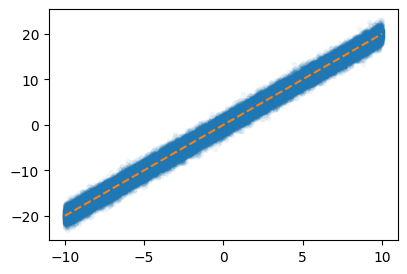

In [28]:
plt.plot(x,y,'.',alpha=0.05)
plt.plot(x,2*x,'--')

`-` 데이터의 크기가 커지는 순간 `X.to("cuda:0")`, `y.to("cuda:0")` 쓰면 난리나겠는걸? 

`-` 데이터를 100개중에 1개만 꼴로만 쓰면 어떨까? 

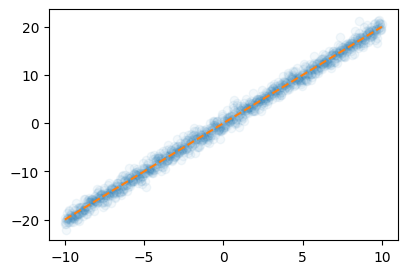

In [35]:
plt.plot(x[::100],y[::100],'o',alpha=0.05)
plt.plot(x,2*x,'--')

- 대충 이거만 가지고 적합해도 충분히 정확할것 같은데?

## B. X,y 데이터를 굳이 모두 GPU에 넘겨야 하는가?

`-` 데이터셋을 짝홀로 나누어서 번갈아가면서 GPU에 올렸다 내렸다하면 안되나? 

`-` 아래의 알고리즘을 생각해보자. 

1. 데이터를 반으로 나눈다. 
2. 짝수obs의 x,y 그리고 net의 모든 파라메터를 GPU에 올린다. 
3. yhat, loss, grad, update 수행
4. 짝수obs의 x,y를 GPU메모리에서 내린다. 그리고 홀수obs의 x,y를 GPU메모리에 올린다. 
5. yhat, loss, grad, update 수행 
6. 홀수obs의 x,y를 GPU메모리에서 내린다. 그리고 짝수obs의 x,y를 GPU메모리에 올린다. 
7. 반복 

> 이러면 되는거아니야???? ---> 맞아요

## C. 경사하강법, 확률적경사하강법, 미니배치 경사하강법 

10개의 샘플이 있다고 가정. $\{(x_i,y_i)\}_{i=1}^{10}$

`# ver1` --  모든 샘플을 이용하여 slope 계산

(epoch 1) $loss=\sum_{i=1}^{10}(y_i-w_0-w_1x_i)^2 \to slope  \to update$

(epoch 2) $loss=\sum_{i=1}^{10}(y_i-w_0-w_1x_i)^2 \to slope  \to update$

...

> 우리가 항상 이렇게 했죠!

`# ver2` -- 하나의 샘플만을 이용하여 slope 계산

(epoch 1) 

- $loss=(y_1-w_0-w_1x_1)^2 \to slope \to update$
- $loss=(y_2-w_0-w_1x_2)^2 \to slope \to update$
- ...
- $loss=(y_{10}-w_0-w_1x_{10})^2  \to  slope  \to  update$

(epoch 2) 

- $loss=(y_1-w_0-w_1x_1)^2  \to slope  \to  update$
- $loss=(y_2-w_0-w_1x_2)^2  \to slope  \to  update$
- ...
- $loss=(y_{10}-w_0-w_1x_{10})^2  \to  slope  \to  update$

...

`# ver3` -- $m (\leq n)$ 개의 샘플을 이용하여 slope 계산

$m=3$이라고 하자. 

(epoch 1) 

- $loss=\sum_{i=1}^{3}(y_i-w_0-w_1x_i)^2  \to  slope  \to  update$
- $loss=\sum_{i=4}^{6}(y_i-w_0-w_1x_i)^2  \to  slope  \to  update$
- $loss=\sum_{i=7}^{9}(y_i-w_0-w_1x_i)^2  \to  slope  \to  update$
- $loss=(y_{10}-w_0-w_1x_{10})^2  \to  slope  \to  update$

(epoch 2) 

- $loss=\sum_{i=1}^{3}(y_i-w_0-w_1x_i)^2  \to  slope  \to  update$
- $loss=\sum_{i=4}^{6}(y_i-w_0-w_1x_i)^2  \to  slope  \to  update$
- $loss=\sum_{i=7}^{9}(y_i-w_0-w_1x_i)^2  \to  slope  \to  update$
- $loss=(y_{10}-w_0-w_1x_{10})^2  \to  slope  \to  update$

...

## D. 용어의 정리 

**옛날**

`-` ver1: gradient descent, batch gradient descent

`-` ver2: stochastic gradient descent

`-` ver3: mini-batch gradient descent, mini-batch stochastic gradient descent

**요즘**

`-` ver1: gradient descent

`-` ver2: stochastic gradient descent with batch size = 1

`-` **ver3: stochastic gradient descent**
- https://www.deeplearningbook.org/contents/optimization.html, 알고리즘 8-1 참고.

## E. Dataset(`ds`), DataLoader(`dl`)

> 취지는 알겠으나, C의 과정을 실제 구현하려면 진짜 어려움.. (입코딩과 손코딩의 차이) --> 이걸 해결하기 위해서 파이토치에서는 DataLoader라는 오브젝트를 준비했음!

`-` ds: 섭스크립터블함

In [36]:
x=torch.tensor(range(10)).float().reshape(-1,1)
y=torch.tensor([1.0]*5+[0.0]*5).reshape(-1,1)
torch.concat([x,y],axis=1)

tensor([[0., 1.],
        [1., 1.],
        [2., 1.],
        [3., 1.],
        [4., 1.],
        [5., 0.],
        [6., 0.],
        [7., 0.],
        [8., 0.],
        [9., 0.]])

In [37]:
ds=torch.utils.data.TensorDataset(x,y)
ds

In [38]:
ds.tensors 
# 생긴건 ds.tensors = (x,y) 임

(tensor([[0.],
         [1.],
         [2.],
         [3.],
         [4.],
         [5.],
         [6.],
         [7.],
         [8.],
         [9.]]),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]))

In [39]:
ds[0],(x,y)[0] # (x,y) 튜플자체는 아님.. 인덱싱이 다르게 동작

((tensor([0.]), tensor([1.])),
 tensor([[0.],
         [1.],
         [2.],
         [3.],
         [4.],
         [5.],
         [6.],
         [7.],
         [8.],
         [9.]]))

`-` dl: 섭스크립터블하지 않지만 이터러블함 

In [40]:
dl=torch.utils.data.DataLoader(ds,batch_size=3)
#set(dir(dl)) & {'__iter__'}

In [41]:
for xi,yi in dl:
    print(f"x_batch:{xi.tolist()} \t y_batch:{yi.tolist()}")

x_batch:[[0.0], [1.0], [2.0]] 	 y_batch:[[1.0], [1.0], [1.0]]
x_batch:[[3.0], [4.0], [5.0]] 	 y_batch:[[1.0], [1.0], [0.0]]
x_batch:[[6.0], [7.0], [8.0]] 	 y_batch:[[0.0], [0.0], [0.0]]
x_batch:[[9.0]] 	 y_batch:[[0.0]]


`-` 마지막관측치는 뭔데 단독으로 업데이트하냐?? --> shuffle True 같이 자잘한 옵션도 있음.. 

In [42]:
dl = torch.utils.data.DataLoader(ds,batch_size=3,shuffle=True)
for xi,yi in dl:
    print(f'x_batch={xi.tolist()} \t y_batch={yi.tolist()}')

x_batch=[[4.0], [6.0], [8.0]] 	 y_batch=[[1.0], [0.0], [0.0]]
x_batch=[[7.0], [3.0], [5.0]] 	 y_batch=[[0.0], [1.0], [0.0]]
x_batch=[[1.0], [9.0], [2.0]] 	 y_batch=[[1.0], [0.0], [1.0]]
x_batch=[[0.0]] 	 y_batch=[[1.0]]


## F. ds, dl을 이용한 MNIST 구현

`-` 목표: 확률적경사하강법과 그냥 경사하강법의 성능을 "동일 반복횟수"로 비교해보자.

- batch_size = 2048로 설정할것 

`-` 그냥 경사하강법 -- 미니배치 안쓰는 학습, 우리가 맨날하는 그거

In [39]:
## Step1: 데이터준비 
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
to_tensor = torchvision.transforms.ToTensor()
X0 = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==0])
X1 = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==1])
X = torch.concat([X0,X1],axis=0).reshape(-1,784)
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters())
## Step3: fit  
for epoc in range(700):
    # step1 
    yhat = net(X)
    # step2 
    loss = loss_fn(yhat,y)
    # step3     
    loss.backward()
    # step4 
    optimizr.step()
    optimizr.zero_grad()
## Step4: Predict 
((yhat > 0.5)*1.0 ==  y).float().mean()

tensor(0.9953)

`-` "확률적"경사하강법 -- 미니배치 쓰는 학습 

In [40]:
## Step1: 데이터준비 
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
to_tensor = torchvision.transforms.ToTensor()
X0 = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==0])
X1 = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==1])
X = torch.concat([X0,X1],axis=0).reshape(-1,784)
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=2048)
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters())
# ## Step3: fit  
for epoc in range(100):
    for xi,yi in dl:        
        # step1 
        #yihat = net(xi)
        # step2 
        loss = loss_fn(net(xi),yi)
        # step3     
        loss.backward()
        # step4 
        optimizr.step()
        optimizr.zero_grad()
# ## Step4: Predict 
((net(X) > 0.5)*1.0 ==  y).float().mean()

tensor(0.9931)

`-` GPU를 활용하는 "확률적"경사하강법 -- 실제적으로는 이게 최종알고리즘 

In [41]:
## Step1: 데이터준비 
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
to_tensor = torchvision.transforms.ToTensor()
X0 = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==0])
X1 = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==1])
X = torch.concat([X0,X1],axis=0).reshape(-1,784)
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=2048)
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(1)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
).to("cuda:0")
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters())
## Step3: fit  
for epoc in range(100):
    for xi,yi in dl:        
        # step1 
        # step2 
        loss = loss_fn(net(xi.to("cuda:0")),yi.to("cuda:0"))
        # step3     
        loss.backward()
        # step4 
        optimizr.step()
        optimizr.zero_grad()
# ## Step4: Predict
net.to("cpu")
((net(X) > 0.5)*1.0 ==  y).float().mean()

tensor(0.9931)

# 5. 다중클래스 분류

## A. 결론 (그냥 외우세요)

`-` 2개의 class를 구분하는 문제가 아니라 $k$개의 class를 구분해야 한다면? 

***일반적인 개념*** 

- 손실함수: BCE loss $\to$ Cross Entropy loss 
- 마지막층의 선형변환: torch.nn.Linear(?,1) $\to$ torch.nn.Linear(?,k) 
- **마지막층의 활성화: sig $\to$ softmax**

***파이토치 한정*** 

- **y의형태: (n,) vector + int형 // (n,k) one-hot encoded matrix + float형**
- 손실함수: torch.nn.BCEWithLogitsLoss,  $\to$ torch.nn.CrossEntropyLoss
- 마지막층의 선형변환: torch.nn.Linear(?,1) $\to$ torch.nn.Linear(?,k) 
- **마지막층의 활성화: None $\to$ None (손실함수에 이미 마지막층의 활성화가 포함)**

## B. 실습: 3개의 클래스를 구분 

`-` 정리된 코드1: 통계잘하는데 파이토치 못쓰는 사람의 코드 

In [ ]:
## Step1: 데이터준비 
path = fastai.data.external.untar_data('https://s3.amazonaws.com/fast-ai-imageclas/mnist_png.tgz')
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/2').ls()])
X = torch.concat([X0,X1,X2]).reshape(-1,1*28*28)/255
y = torch.nn.functional.one_hot(torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))).float()
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,3),
#    torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
## Step3: 적합 
for epoc in range(100):
    ## step1 
    netout = net(X)
    ## step2 
    loss = loss_fn(netout,y)
    ## step3 
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()
    
## Step4: 적합 (혹은 적합결과확인)
(netout.argmax(axis=1) == y.argmax(axis=1)).float().mean()

tensor(0.9827)

`-` 정리된 코드2: 파이토치를 잘하는 사람의 코드 

In [ ]:
## Step1: 데이터준비 
path = fastai.data.external.untar_data('https://s3.amazonaws.com/fast-ai-imageclas/mnist_png.tgz')
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/2').ls()])
X = torch.concat([X0,X1,X2]).reshape(-1,1*28*28)/255
#y = torch.nn.functional.one_hot(torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))).float()
y = torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,3),
#    torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
## Step3: 적합 
for epoc in range(100):
    ## step1 
    netout = net(X)
    ## step2 
    loss = loss_fn(netout,y)
    ## step3 
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()
## Step4: 적합 (혹은 적합결과확인)    
(netout.argmax(axis=1) == y).float().mean()

tensor(0.9827)

- 완전같은코드임 

## C. Softmax 

`-` 눈치: softmax를 쓰기 직전의 숫자들은 (n,k)꼴로 되어있음. 각 observation 마다 k개의 숫자가 있는데, 그중에서 유난히 큰 하나의 숫자가 있음. 

In [ ]:
net(X)

tensor([[ 4.4836, -4.5924, -3.4632],
        [ 1.9839, -3.4456,  0.3030],
        [ 5.9082, -7.5250, -0.7634],
        ...,
        [-0.8089, -0.8294,  0.6012],
        [-2.1901, -0.4458,  0.7465],
        [-1.6856, -2.2825,  5.1892]], grad_fn=<AddmmBackward0>)

In [ ]:
y

tensor([0, 0, 0,  ..., 2, 2, 2])

`-` 수식 

- $\text{sig}(u)=\frac{e^u}{1+e^u}$
- $\text{softmax}({\boldsymbol u})=\text{softmax}([u_1,u_2,\dots,u_k])=\big[ \frac{e^{u_1}}{e^{u_1}+\dots e^{u_k}},\dots,\frac{e^{u_k}}{e^{u_1}+\dots e^{u_k}}\big]$

`-` torch.nn.Softmax() 손계산 

(예시1) -- 잘못계산 

In [ ]:
softmax = torch.nn.Softmax(dim=0)

In [ ]:
netout = torch.tensor([[-2.0,-2.0,0.0],
                        [3.14,3.14,3.14],
                        [0.0,0.0,2.0],
                        [2.0,2.0,4.0],
                        [0.0,0.0,0.0]])
netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [ ]:
softmax(netout) 

tensor([[0.0041, 0.0041, 0.0115],
        [0.7081, 0.7081, 0.2653],
        [0.0306, 0.0306, 0.0848],
        [0.2265, 0.2265, 0.6269],
        [0.0306, 0.0306, 0.0115]])

(예시2) -- 이게 맞게 계산되는 것임 

In [ ]:
softmax = torch.nn.Softmax(dim=1)

In [ ]:
netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [ ]:
softmax(netout)

tensor([[0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333],
        [0.1065, 0.1065, 0.7870],
        [0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333]])

(예시3) -- 차원을 명시안하면 맞게 계산해주고 경고 줌 

In [ ]:
softmax = torch.nn.Softmax()

In [ ]:
netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [ ]:
softmax(netout)

/home/cgb3/anaconda3/envs/dl2024/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333],
        [0.1065, 0.1065, 0.7870],
        [0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333]])

(예시4) -- 진짜 손계산 

In [ ]:
netout 

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [ ]:
torch.exp(netout)

tensor([[ 0.1353,  0.1353,  1.0000],
        [23.1039, 23.1039, 23.1039],
        [ 1.0000,  1.0000,  7.3891],
        [ 7.3891,  7.3891, 54.5981],
        [ 1.0000,  1.0000,  1.0000]])

In [ ]:
0.1353/(0.1353 + 0.1353 + 1.0000), 0.1353/(0.1353 + 0.1353 + 1.0000), 1.0000/(0.1353 + 0.1353 + 1.0000) # 첫 obs

(0.10648512513773022, 0.10648512513773022, 0.7870297497245397)

In [ ]:
torch.exp(netout[1])/torch.exp(netout[1]).sum() # 두번째 obs 

tensor([0.3333, 0.3333, 0.3333])

## D. CrossEntropyLoss

`-` 수식 

***`# 2개의 카테고리`***

`-` 예제1: BCELoss vs BCEWithLogisticLoss

In [ ]:
y = torch.tensor([0,0,1]).reshape(-1,1).float()
netout = torch.tensor([-1, 0, 1]).reshape(-1,1).float()
y,netout

(tensor([[0.],
         [0.],
         [1.]]),
 tensor([[-1.],
         [ 0.],
         [ 1.]]))

In [ ]:
# 계산방법1: 공식암기
sig = torch.nn.Sigmoid()
yhat = sig(netout)
- torch.sum(torch.log(yhat)*y + torch.log(1-yhat)*(1-y))/3

tensor(0.4399)

In [ ]:
# 계산방법2: torch.nn.BCELoss() 이용
sig = torch.nn.Sigmoid()
yhat = sig(netout)
loss_fn = torch.nn.BCELoss()
loss_fn(yhat,y)

tensor(0.4399)

In [ ]:
# 계산방법3: torch.nn.BCEWithLogitsLoss() 이용
loss_fn = torch.nn.BCEWithLogitsLoss()
loss_fn(netout,y)

tensor(0.4399)

`-` 예제2: BCEWithLogisticLoss vs CrossEntropyLoss

In [ ]:
torch.concat([sig(netout),1-sig(netout)],axis=1)

tensor([[0.2689, 0.7311],
        [0.5000, 0.5000],
        [0.7311, 0.2689]])

In [ ]:
netout = torch.tensor([[3,2],[2,2],[5,6]]).float()
y = torch.tensor([[1,0],[1,0],[0,1]]).float()
y,netout #,netout[:,[1]]-netout[:,[0]]

(tensor([[1., 0.],
         [1., 0.],
         [0., 1.]]),
 tensor([[3., 2.],
         [2., 2.],
         [5., 6.]]))

In [ ]:
softmax(netout)

tensor([[0.7311, 0.2689],
        [0.5000, 0.5000],
        [0.2689, 0.7311]])

In [ ]:
# 계산방법1: 공식암기
-torch.sum(torch.log(softmax(netout))*y)/3

tensor(0.4399)

In [ ]:
# 계산방법2: torch.nn.CrossEntropyLoss() 이용 + y는 one-hot으로 정리
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn(netout,y)

tensor(0.4399)

In [ ]:
# 계산방법3: torch.nn.CrossEntropyLoss() 이용 + y는 0,1 로 정리
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn(netout,y)

tensor(0.4399)

`#`

***`# 3개의 카테고리`***

In [ ]:
y = torch.tensor([2,1,2,2,0])
y_onehot = torch.nn.functional.one_hot(y)
netout = torch.tensor(
    [[-2.0000, -2.0000,  0.0000],
     [ 3.1400,  3.1400,  3.1400],
     [ 0.0000,  0.0000,  2.0000],
     [ 2.0000,  2.0000,  4.0000],
     [ 0.0000,  0.0000,  0.0000]]
)
y,y_onehot

(tensor([2, 1, 2, 2, 0]),
 tensor([[0, 0, 1],
         [0, 1, 0],
         [0, 0, 1],
         [0, 0, 1],
         [1, 0, 0]]))

In [ ]:
## 방법1 -- 추천X
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn(netout,y_onehot.float())

tensor(0.5832)

In [ ]:
## 방법2 -- 추천O
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn(netout,y)

tensor(0.5832)

In [ ]:
## 방법3 -- 공식.. (이걸 쓰는사람은 없겠지?)
softmax = torch.nn.Softmax() 
loss_fn = torch.nn.CrossEntropyLoss()
- torch.sum(torch.log(softmax(netout))*y_onehot)/5

tensor(0.5832)

`#`

`-` 계산하는 공식을 아는것도 중요한데 torch.nn.CrossEntropyLoss() 에는 softmax 활성화함수가 이미 포함되어 있다는 것을 확인하는 것이 더 중요함. 

`-` torch.nn.CrossEntropyLoss() 는 사실 torch.nn.CEWithSoftmaxLoss() 정도로 바꾸는 것이 더 말이 되는 것 같다. 

## E. Minor Topic: 이진분류와 CrossEntropy

`-` 2개의 클래스일경우에도 CrossEntropy를 쓸 수 있지 않을까? 

In [ ]:
## Step1: 데이터준비 
path = fastai.data.external.untar_data(fastai.data.external.URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1]).reshape(-1,1*28*28)/255
y = torch.tensor([0]*len(X0) + [1]*len(X1))
## Step2: 학습가능한 오브젝트 생성
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,2),
    #torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
## Step3: fit  
for epoc in range(70): 
    ## 1 
    ## 2 
    loss= loss_fn(net(X),y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad() 
## Step4: Predict 
softmax = torch.nn.Softmax()
(net(X).argmax(axis=1) == y).float().mean()

tensor(0.9983)

`-` 이진분류문제 = "y=0 or y=1" 을 맞추는 문제 = 성공과 실패를 맞추는 문제 = 성공확률과 실패확률을 추정하는 문제 

`-` softmax, sigmoid

- softmax: (실패확률, 성공확률) 꼴로 결과가 나옴 // softmax는 실패확률과 성공확률을 둘다 추정한다. 
- sigmoid: (성공확률) 꼴로 결과가 나옴 // sigmoid는 성공확률만 추정한다. 

`-` 그런데 "실패확률=1-성공확률" 이므로 사실상 둘은 같은걸 추정하는 셈이다. (성공확률만 추정하면 실패확률은 저절로 추정되니까) 

`-` 즉 아래는 같은 표현력을 가진 모형이다. 

![](https://raw.githubusercontent.com/guebin/DL2024/cdbdf23589efc2198260ab9c749f1757f67a128d/posts/05wk-1-fig2.svg)

![](https://raw.githubusercontent.com/guebin/DL2024/cdbdf23589efc2198260ab9c749f1757f67a128d/posts/05wk-1-fig1.svg)

`-` 둘은 같은 표현력을 가진 모형인데 학습할 파라메터는 sigmoid의 경우가 더 적다. $\to$ sigmoid를 사용하는 모형이 비용은 싸고 효과는 동일하다는 말 $\to$ 이진분류 한정해서는 softmax를 쓰지말고 sigmoid를 써야함. 

- softmax가 갑자기 너무 안좋아보이는데 sigmoid는 k개의 클래스로 확장이 불가능한 반면 softmax는 확장이 용이하다는 장점이 있음.

## F. 정리 

`-` 결론 

1. 소프트맥스는 시그모이드의 확장이다. 
2. 클래스의 수가 2개일 경우에는 (Sigmoid, BCEloss) 조합을 사용해야 하고 클래스의 수가 2개보다 클 경우에는 (Softmax, CrossEntropyLoss) 를 사용해야 한다. 


`-` 그런데 사실.. 클래스의 수가 2개일 경우일때 (Softmax, CrossEntropyLoss)를 사용해도 그렇게 큰일나는것은 아니다. (그냥 좀 비효율적인 느낌이 드는 것 뿐임. 흑백이미지를 칼라잉크로 출력하는 느낌) 

***참고***

|$y$|분포가정|마지막층의 활성화함수|손실함수|
|:--:|:--:|:--:|:--:|
|3.45, 4.43, ... (연속형) |정규분포|None (or Identity)|MSE|
|0 or 1|이항분포 with $n=1$ (=베르누이) |Sigmoid| BCE|
|[0,0,1], [0,1,0], [1,0,0]| 다항분포 with $n=1$|Softmax| Cross Entropy |

# Appendix -- 신경망의 표현 

신경망의 표현: ${\boldsymbol x} \to \hat{\boldsymbol y}$ 로 가는 과정을 그림으로 표현

## 예제1: $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(1)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(1)}} =\underset{(n,1)}{\hat{\boldsymbol y}}$

`-` 모든 observation과 가중치를 명시한 버전 

**(표현1)**

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-4-output-1.svg)

- 단점: 똑같은 그림의 반복이 너무 많음

`-` observation 반복을 생략한 버전들 

**(표현2)** 모든 $i$에 대하여 아래의 그림을 반복한다고 하면 (표현1)과 같다. 

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-5-output-1.svg)

**(표현3)** 그런데 (표현2)에서 아래와 같이 $x_i$, $y_i$ 대신에 간단히 $x$, $y$로 쓰는 경우도 많음

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-6-output-1.svg)

`-` 1을 생략한 버전들 

**(표현4)** bais=False 대신에 bias=True를 주면 1을 생략할 수 있음 

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-7-output-1.svg)

**(표현4의 수정)** $\hat{w}_1$대신에 $\hat{w}$를 쓰는 것이 더 자연스러움 

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-8-output-1.svg)

**(표현5)** 선형변환의 결과는 아래와 같이 $u$로 표현하기도 한다. 

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-9-output-1.svg)

> 다이어그램은 그리는 사람의 취향에 따라 그리는 방법이 조금씩 다릅니다. 즉 교재마다 달라요. 

## 예제2: $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}} =\underset{(n,1)}{\hat{\boldsymbol y}}$

**참고: 코드로 표현**

```Python
torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=1),
    torch.nn.Sigmoid()
)
```

`-` 이해를 위해서 예젠에 다루었던 아래의 상황을 고려하자. 

![](https://guebin.github.io/DL2024/posts/03wk-2_files/figure-html/cell-11-output-1.png)

**(강의노트의 표현)**

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-10-output-1.svg)

**(좀 더 일반화된 표현)** 상황을 일반화하면 아래와 같다. 

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-11-output-1.svg)

`*` Layer의 개념: ${\bf X}$에서 $\hat{\boldsymbol y}$로 가는 과정은 "선형변환+비선형변환"이 반복되는 구조이다. "선형변환+비선형변환"을 하나의 세트로 보면 아래와 같이 표현할 수 있다. 

- $\underset{(n,1)}{\bf X}  \overset{l_1}{\to} \left( \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \right) \overset{l_2}{\to} \left(\underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}\right), \quad  \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{net({\bf X})}=\underset{(n,1)}{\hat{\boldsymbol y}}$

이것을 다이어그램으로 표현한다면 아래와 같다. 

**(선형+비선형을 하나의 Layer로 묶은 표현)**

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-12-output-1.svg)

***Layer를 세는 방법***

- 제 방식: 학습가능한 파라메터가 몇층으로 있는지... <-- 이것만 기억하세여
- 일부 교재 설명: 입력층은 계산하지 않음, activation layer는 계산하지 않음. <-- 무시하세요.. 이러면 헷갈립니다.. 
- 위의 예제의 경우 `number of layer = 2` 이다. 

***Hidden Layer의 수를 세는 방법*** 

- 제 방식: `Hidden Layer의 수 = Layer의 수 -1` <-- 이걸 기억하세여..  
- 일부 교재 설명: `Layer의 수 = Hidden Layer의 수 + 출력층의 수 = Hidden Layer의 수 + 1` <-- 기억하지 마세여 
- 위의 예제의 경우 `number of hidden layer = 1` 이다. 

::: {.callout-important}
무조건 학습가능한 파라메터가 몇겹으로 있는지만 판단하세요. 딴거 아무것도 생각하지마세여

```Python
## 예시1 -- 2층 (히든레이어는 1층)
torch.nn.Sequential(
    torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
    torch.nn.ReLU(),
    torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
)
```

```Python
## 예시2 -- 2층 (히든레이어는 1층)
torch.nn.Sequential(
    torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
    torch.nn.ReLU(),
    torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
    torch.nn.Sigmoid(),
)
```

```Python
## 예시3 -- 1층 (히든레이어는 없음!!)
torch.nn.Sequential(
    torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
) 
```

```Python
## 예시4 -- 1층 (히든레이어는 없음!!)
torch.nn.Sequential(
    torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
    torch.nn.Sigmoid()
) 
```

```Python
## 예시5 -- 3층 (히든레이어는 2층)
torch.nn.Sequential(
    torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
    torch.nn.Sigmoid()
    torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
    torch.nn.Sigmoid()
    torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층    
) 
```

```Python
## 예시6 -- 3층 (히든레이어는 2층)
torch.nn.Sequential(
    torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
    torch.nn.ReLU()
    torch.nn.Dropout(??)
    torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
    torch.nn.ReLU()
    torch.nn.Dropout(??)
    torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층  
    torch.nn.Sigmoid()
) 
```
:::

::: {.callout-important}

문헌에 따라서 레이어를 세는 개념이 제가 설명한 방식과 다른경우가 있습니다. 제가 설명한 방식보다 1씩 더해서 셉니다. 즉 아래의 경우 레이어를 3개로 카운트합니다. 
```Python
## 예시1 -- 문헌에 따라 3층으로 세는 경우가 있음 (히든레이어는 1층)
torch.nn.Sequential(
    torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
    torch.nn.ReLU(),
    torch.nn.Linear(??,??), ## <-- 학습해야할 가중치가 있는 층
    torch.nn.Sigmoid()
)
```
예를 들어 [여기](https://en.wikipedia.org/wiki/Multilayer_perceptron#Layers)에서는 위의 경우 레이어는 3개라고 설명하고 있습니다. 이러한 카운팅은 **"무시"하세요. 제가 설명한 방식이 맞아요.** [이 링크](https://en.wikipedia.org/wiki/Multilayer_perceptron#Layers) 잘못(?) 나와있는 이유는 아래와 같습니다. 

`-` 진짜 예전에 MLP를 소개할 초창기에서는 위의 경우 Layer를 3개로 셌음. [@rosenblatt1962principles]

`-` 그런데 요즘은 그렇게 안셈.. (그리고 애초에 MLP라는 용어도 잘 안쓰죠..)

참고로 히든레이어의 수는 예전방식이나 지금방식이나 동일하게 카운트하므로 히든레이어만 세면 혼돈이 없습니다. 

:::

`*` node의 개념: $u\to v$로 가는 쌍을 간단히 노드라는 개념을 이용하여 나타낼 수 있음. 

**(노드의 개념이 포함된 그림)**

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-13-output-1.svg)

여기에서 `node의 숫자 = feature의 숫자`와 같이 이해할 수 있다. 즉 아래와 같이 이해할 수 있다. 

**("number of nodes = number of features"로 이해한 그림)**

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-14-output-1.svg)

> 다이어그램의 표현방식은 교재마다 달라서 모든 예시를 달달 외울 필요는 없습니다. 다만 임의의 다이어그램을 보고 대응하는 네트워크를 pytorch로 구현하는 능력은 매우 중요합니다. 

## 예제3: $\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,32)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,32)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$  


**(다이어그램표현)**

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-11-6wk-2_files/figure-html/cell-15-output-1.svg)

- Layer0,1,2 대신에 Input Layer, Hidden Layer, Output Layer로 표현함 

`-` 위의 다이어그램에 대응하는 코드

```Python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=28*28*1,out_features=32),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=32,out_features=1),
    torch.nn.Sigmoid() 
)
```